In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn import metrics
import numpy as np
from tqdm import tqdm

In [2]:
calendar_raw = pd.read_csv('./calendar.csv')
sell_price_raw = pd.read_csv('./sell_prices.csv')
sales_raw = pd.read_csv('./sales_train_validation.csv')

In [3]:
calendar_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [4]:
sell_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [5]:
print('Calendar event name 1: ', calendar_raw['event_name_1'].unique())
print('Calendar event name 2: ', calendar_raw['event_name_2'].unique())
print('Calendar event type 1: ', calendar_raw['event_type_1'].unique())
print('Calendar event type 2: ', calendar_raw['event_type_2'].unique())

Calendar event name 1:  [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
Calendar event name 2:  [nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]
Calendar event type 1:  [nan 'Sporting' 'Cultural' 'National' 'Religious']
Calendar event type 2:  [nan 'Cultural' 'Religious']


In [56]:
event_name_to_id = {str(name): id for id, name in enumerate(calendar_raw['event_name_1'].unique())}
event_id_to_name = {id: str(name) for id, name in enumerate(calendar_raw['event_name_1'].unique())}
event_type_to_id = {str(name): id for id, name in enumerate(calendar_raw['event_type_1'].unique())}
event_id_to_type = {id: str(name) for id, name in enumerate(calendar_raw['event_type_1'].unique())}

item_to_id = {str(name): id for id, name in enumerate(sales_raw['item_id'].unique())}
id_to_item = {id: str(name) for id, name in enumerate(sales_raw['item_id'].unique())}
dept_to_id = {str(name): id for id, name in enumerate(sales_raw['dept_id'].unique())}
id_to_dept = {id: str(name) for id, name in enumerate(sales_raw['dept_id'].unique())}
cat_to_id = {str(name): id for id, name in enumerate(sales_raw['cat_id'].unique())}
id_to_cat = {id: str(name) for id, name in enumerate(sales_raw['cat_id'].unique())}

state_to_id = {str(name): id for id, name in enumerate(sales_raw['state_id'].unique())}
id_to_state = {id: str(name) for id, name in enumerate(sales_raw['state_id'].unique())}

store_to_id = {str(name): id for id, name in enumerate(sales_raw['store_id'].unique())}
id_to_store = {id: str(name) for id, name in enumerate(sales_raw['store_id'].unique())}

In [7]:
sales_raw.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [8]:
sum_sku = sales_raw.drop(columns=['id', 'cat_id', 'dept_id', 'store_id', 'state_id']).groupby(['item_id']).sum()
sum_sku.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6,6,4,6,7,18,10,4,11,10,...,4,4,30,7,5,3,6,2,16,6
FOODS_1_002,4,5,7,4,3,4,1,7,2,4,...,5,9,4,1,3,5,5,3,3,1
FOODS_1_003,14,8,3,6,3,8,13,10,11,6,...,7,3,5,6,3,4,4,3,11,5
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_1_005,34,32,13,20,10,21,18,20,25,41,...,16,14,14,18,18,27,12,15,38,9


<Axes: >

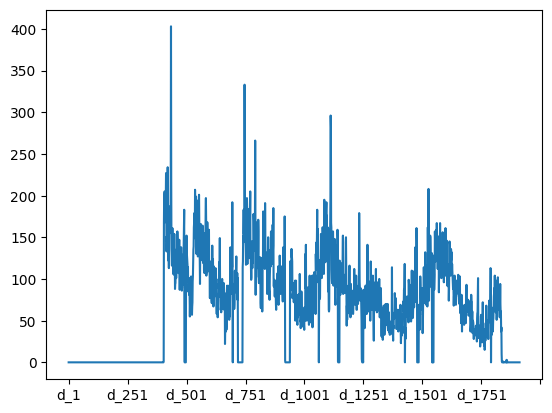

In [9]:
sum_sku.loc['FOODS_1_004'].plot()

In [10]:
sales_sum_cat = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'store_id', 'state_id']).groupby(['cat_id']).sum()
sales_sum_cat.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,18901,...,28682,32007,34497,26151,24948,23632,23317,26704,31927,32654
HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,2615,...,3786,4634,4820,3323,3787,3472,3353,4085,4787,4683
HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,4056,...,9321,11721,12323,8585,8835,8239,8363,9728,12248,12458


<Axes: title={'center': 'Sale sum by each categories'}>

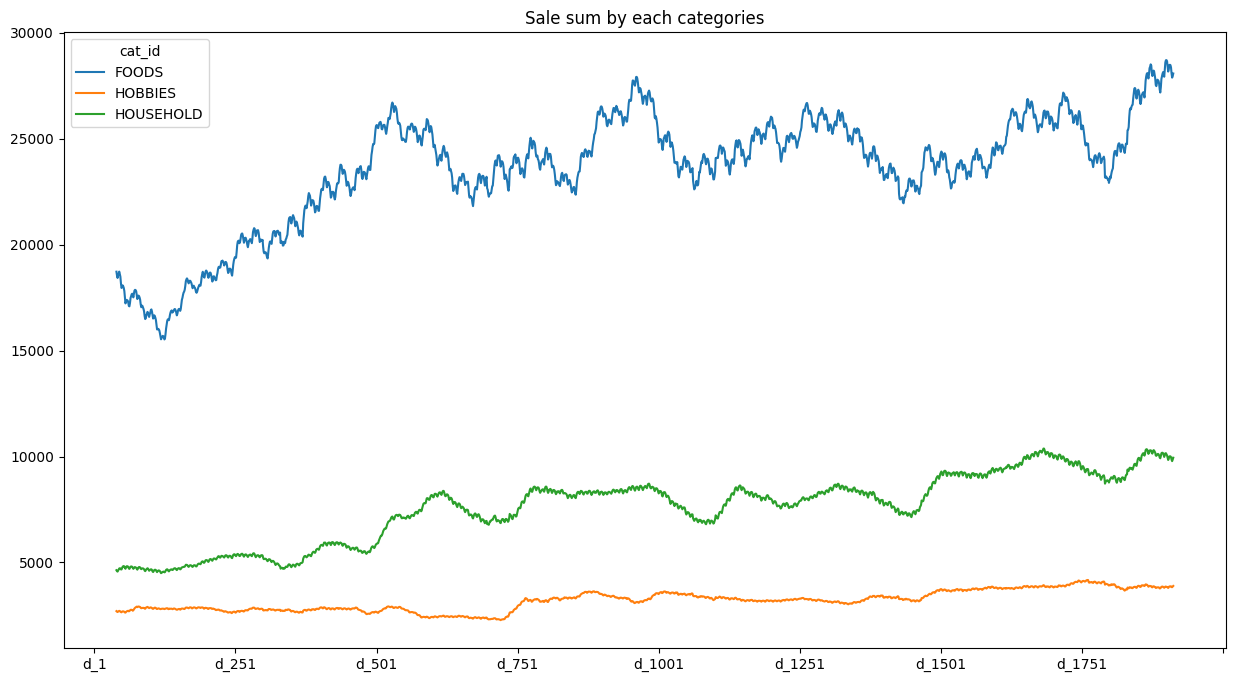

In [11]:
sales_sum_cat.T.rolling(40).mean().plot(figsize=(15,8), title='Sale sum by each categories')

<Axes: title={'center': 'Sum sales by each state'}>

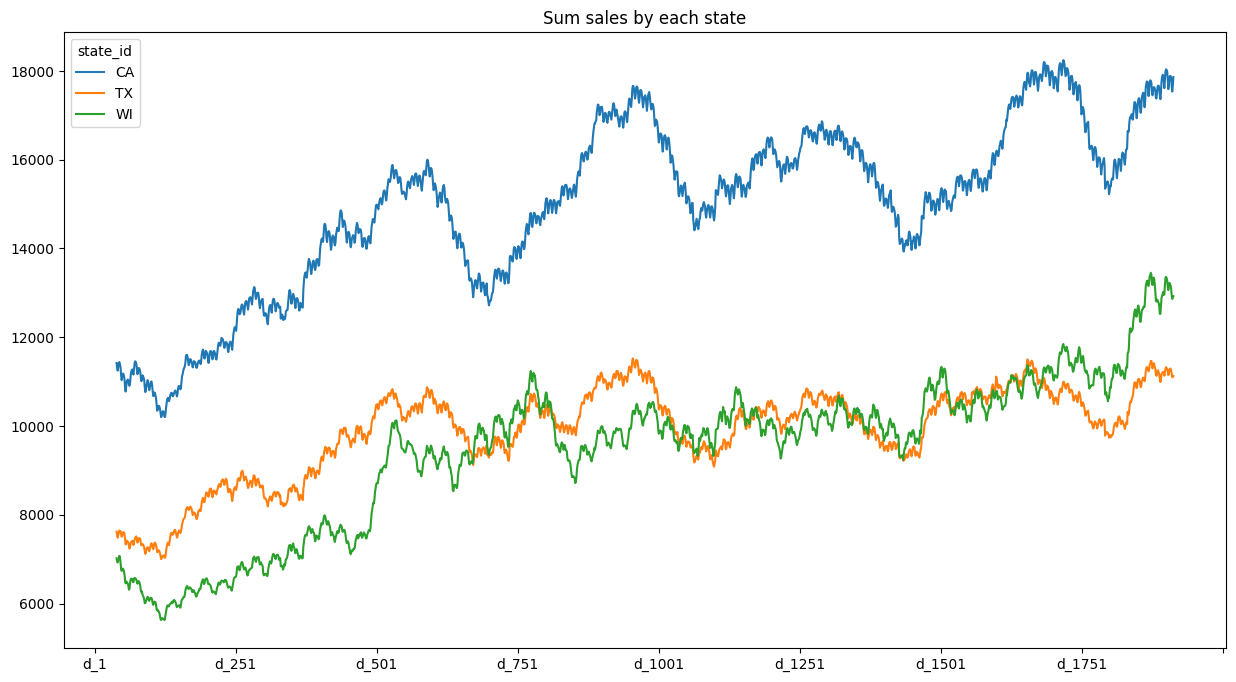

In [12]:
sales_sum_state = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'store_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_state.rolling(40).mean().plot(figsize=(15,8), title='Sum sales by each state')

<Axes: title={'center': 'Sum sales by each store'}>

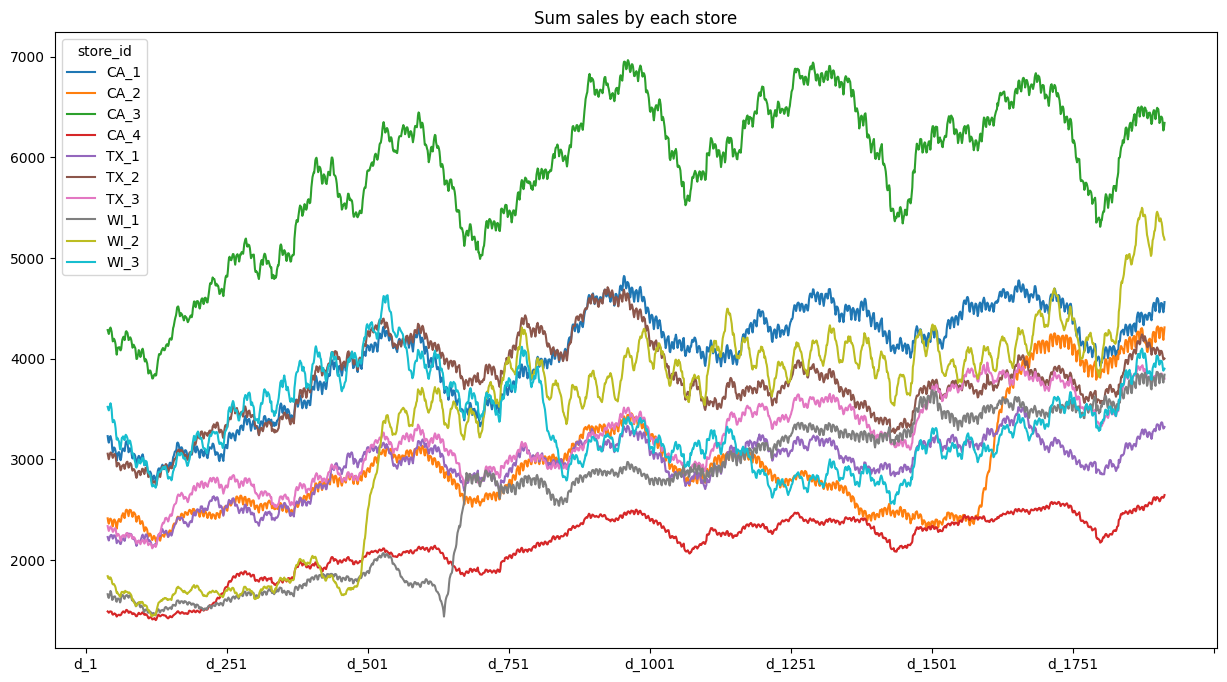

In [13]:
sales_sum_store = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id', 'cat_id']).groupby(['store_id']).sum().T
sales_sum_store.rolling(40).mean().plot(figsize=(15,8), title='Sum sales by each store')

<Axes: >

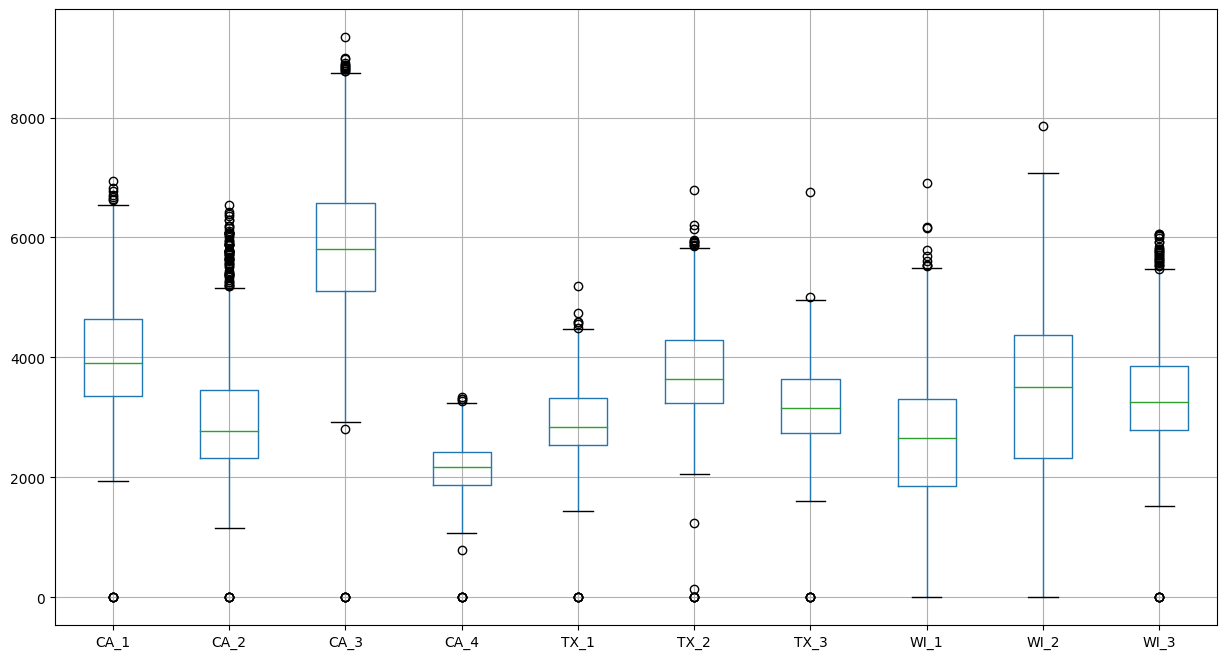

In [14]:
sales_sum_store.boxplot(figsize=(15,8))

From the box plot, we can see that some day have high sale above q3, so I want to see what happend with the day which have high amount

***
Check the zero sale date to find what happend with it.

In [15]:
sales_sum_zero_ca_1 = sales_sum_store[sales_sum_store['CA_1'] == 0]['CA_1'].reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_zero_ca_1.head()

,CA_1,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,
d_331,0,2011-12-25,11148,Sunday,2,12,2011,Christmas,National,NaN,NaN,0,0,0
d_697,0,2012-12-25,11248,Tuesday,4,12,2012,Christmas,National,NaN,NaN,0,0,0
d_1062,0,2013-12-25,11348,Wednesday,5,12,2013,Christmas,National,NaN,NaN,0,0,0
d_1427,0,2014-12-25,11447,Thursday,6,12,2014,Christmas,National,NaN,NaN,0,0,0
d_1792,0,2015-12-25,11547,Friday,7,12,2015,Christmas,National,NaN,NaN,0,0,0


## By looking at the table we can see that the day with 0 sale is public holiday.

In [16]:
sales_sum_q4_ca_1 = sales_sum_store[sales_sum_store['CA_1'] > 6200]['CA_1'].reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_q4_ca_1.head()

,CA_1,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,
d_736,6232,2013-02-02,11302,Saturday,1,2,2013,NaN,NaN,NaN,NaN,1,0,1
d_925,6308,2013-08-10,11329,Saturday,1,8,2013,NaN,NaN,NaN,NaN,1,0,0
d_926,6276,2013-08-11,11329,Sunday,2,8,2013,NaN,NaN,NaN,NaN,0,1,1
d_940,6948,2013-08-25,11331,Sunday,2,8,2013,NaN,NaN,NaN,NaN,0,0,0
d_946,6544,2013-08-31,11332,Saturday,1,8,2013,NaN,NaN,NaN,NaN,0,0,0


## Most of the high sale is come from saturday and sunday

***
# Effect of snap day

## California state

<Axes: xlabel='snap_CA'>

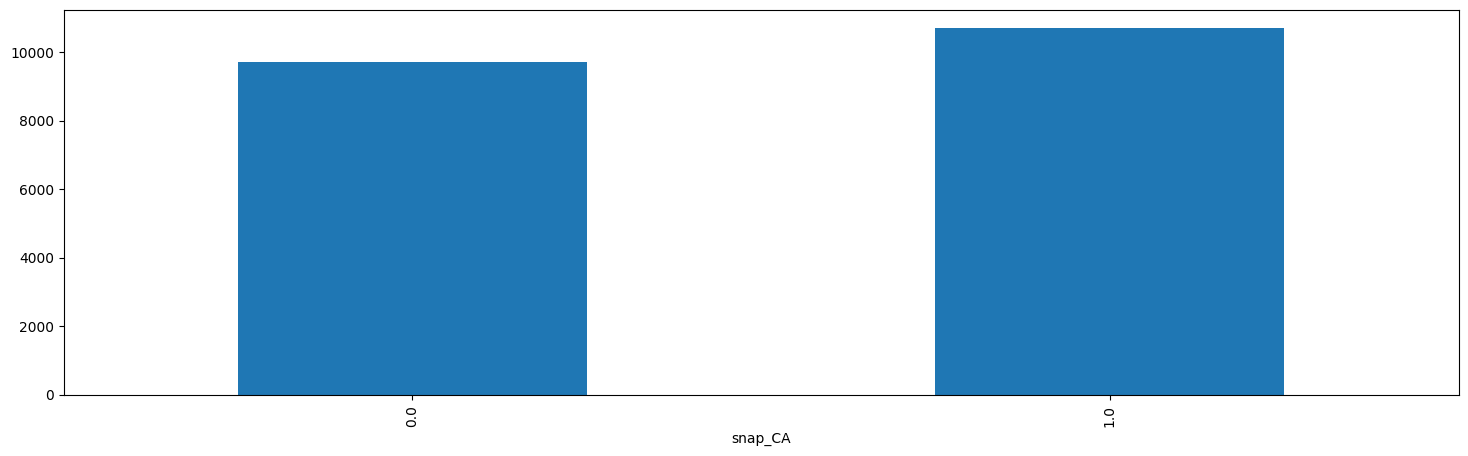

In [17]:
sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_CA_food = sales_sum_state.drop(columns=['TX', 'WI']).reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_CA_food.reset_index().groupby(['snap_CA'])['CA'].mean().plot.bar(figsize=(18,5))

## Texas state

<Axes: xlabel='snap_TX'>

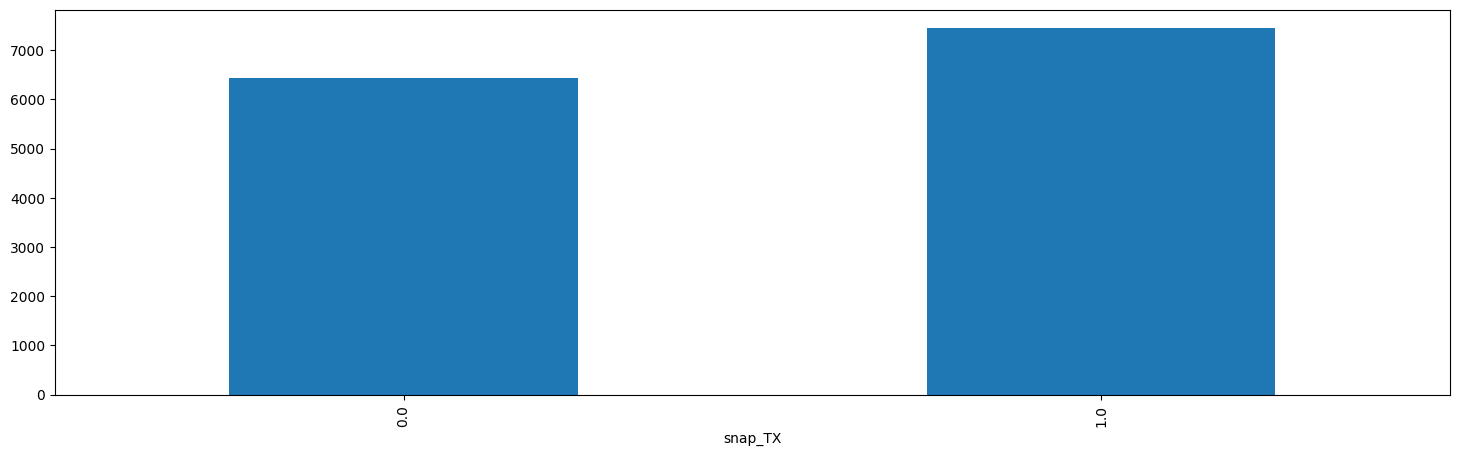

In [18]:
sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_TX_food = sales_sum_state.drop(columns=['CA', 'WI']).reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_TX_food.reset_index().groupby(['snap_TX'])['TX'].mean().plot.bar(figsize=(18,5))

## Iowa state

<Axes: xlabel='snap_WI'>

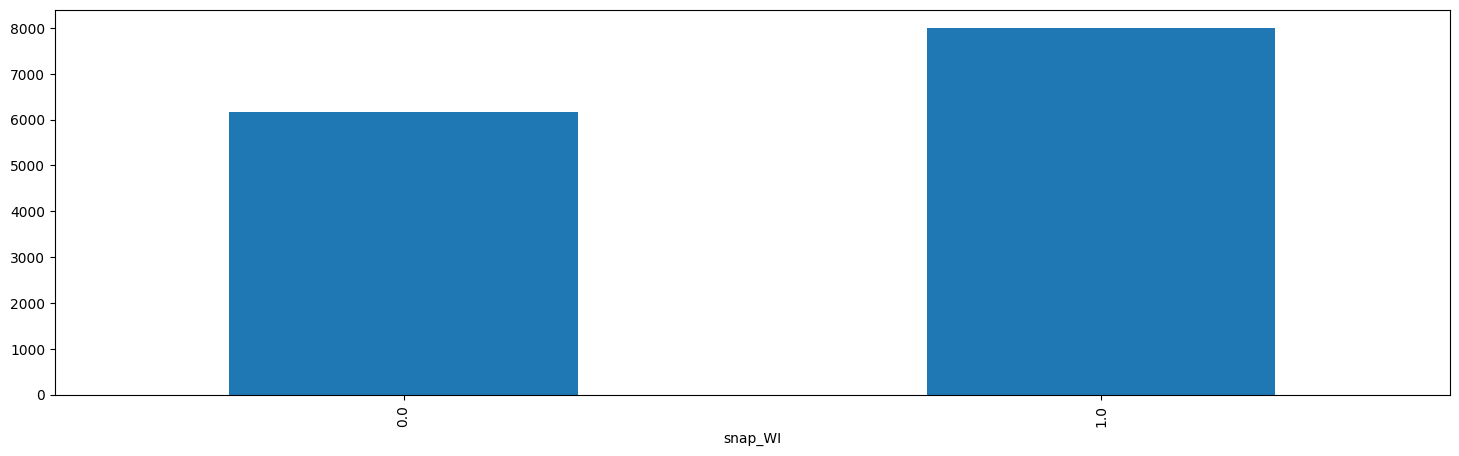

In [19]:
sales_sum_state = sales_raw[sales_raw['cat_id'] == 'FOODS'].drop(columns=['id', 'item_id', 'dept_id', 'cat_id']).groupby(['state_id']).sum().T
sales_sum_WI_food = sales_sum_state.drop(columns=['CA', 'TX']).reset_index().rename(columns={'index': 'd'}).merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_WI_food.reset_index().groupby(['snap_WI'])['WI'].mean().plot.bar(figsize=(18,5))

<h1>Category by week day average testing</h1>

In [20]:
sales_sum_cat = sales_raw.drop(columns=['id', 'item_id', 'dept_id', 'state_id', 'store_id']).groupby(['cat_id']).sum().T
sales_sum_catT = sales_sum_cat.reset_index().rename(columns={'index': 'd'})

Join with date

In [21]:
sales_sum_cat_joindate = sales_sum_catT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_sum_cat_joindate.head()

,FOODS,HOBBIES,HOUSEHOLD,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
d,,,,,,,,,,,,,,,,
d_1,23178,3764,5689,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_2,22758,3357,5634,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_3,17174,2682,3927,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
d_4,18878,2669,3865,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
d_5,14603,1814,2729,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


In [22]:
sales_cat_avg_weekday = sales_sum_cat_joindate[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday.head()

,FOODS,HOBBIES,HOUSEHOLD
weekday,,,
Friday,23264.146520,3323.827839,7638.010989
Monday,22735.402930,2980.336996,7137.227106
Saturday,28077.200730,3930.332117,9539.361314
Sunday,28346.890511,3564.182482,9218.948905
Thursday,20819.956044,2879.615385,6505.435897


<Axes: title={'center': 'Average sale amount by week day from every state'}, xlabel='weekday'>

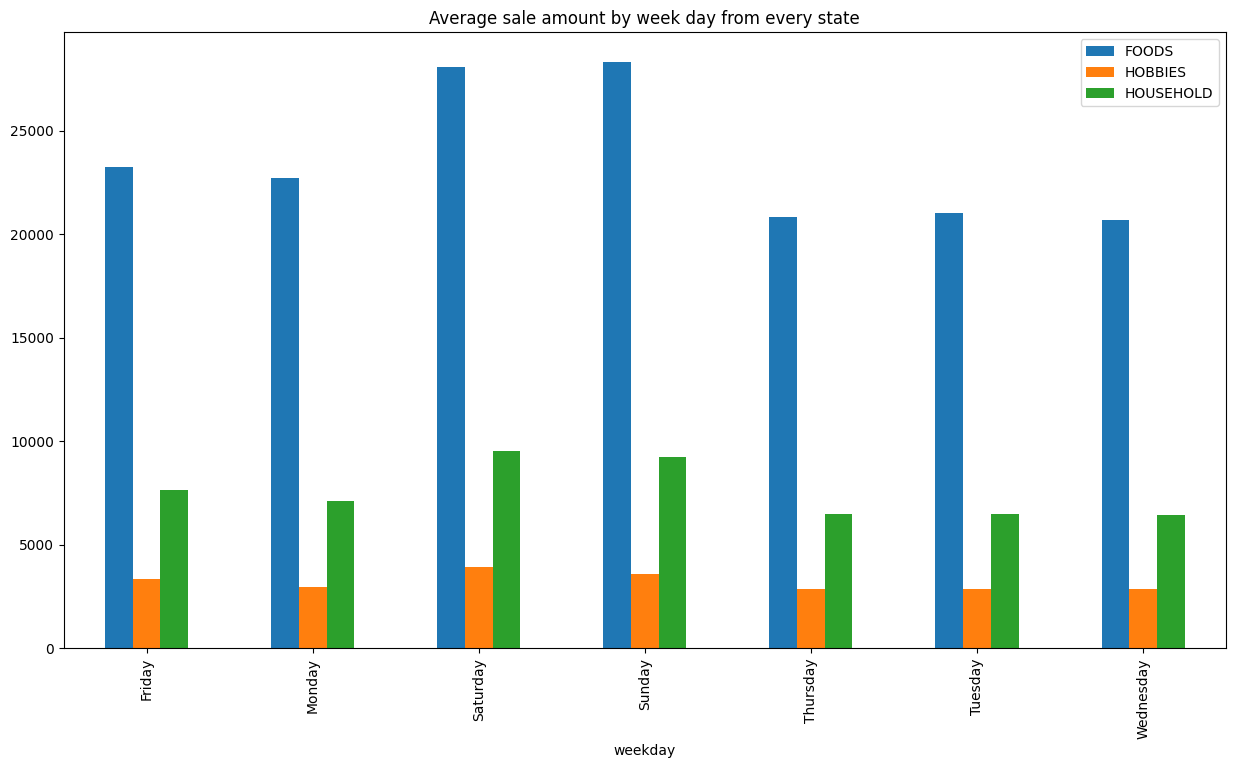

In [23]:
sales_cat_avg_weekday.plot.bar(figsize=(15,8), title='Average sale amount by week day from every state')

<Axes: title={'center': 'Average sale amount by week day in California state'}, xlabel='weekday'>

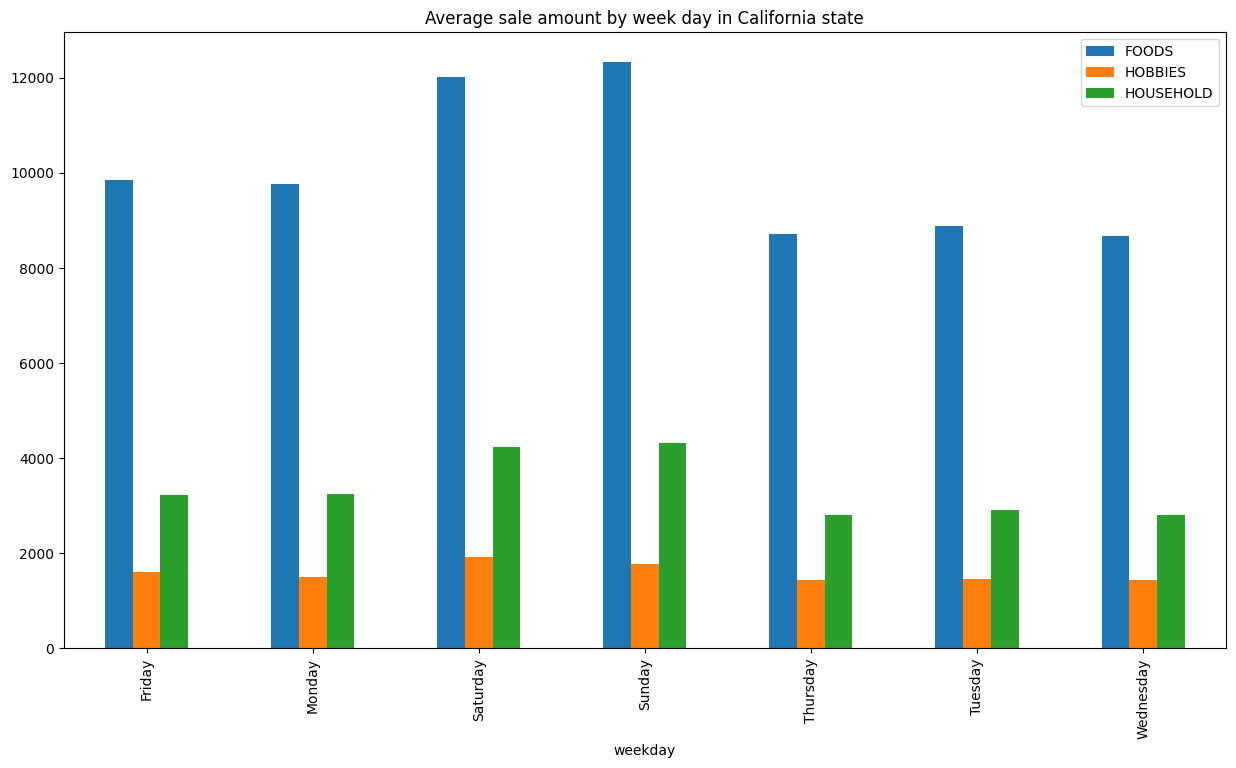

In [24]:
sales_sum_cat_CA = sales_raw[sales_raw['state_id'] == 'CA'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_cat_CAT = sales_sum_cat_CA.reset_index().rename(columns={'index': 'd'})
sales_sum_cat_joindate_CA = sales_sum_cat_CAT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_cat_avg_weekday_CA = sales_sum_cat_joindate_CA[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday_CA.plot.bar(figsize=(15,8), title='Average sale amount by week day in California state')

<Axes: title={'center': 'Average sale amount by week day in Texas state'}, xlabel='weekday'>

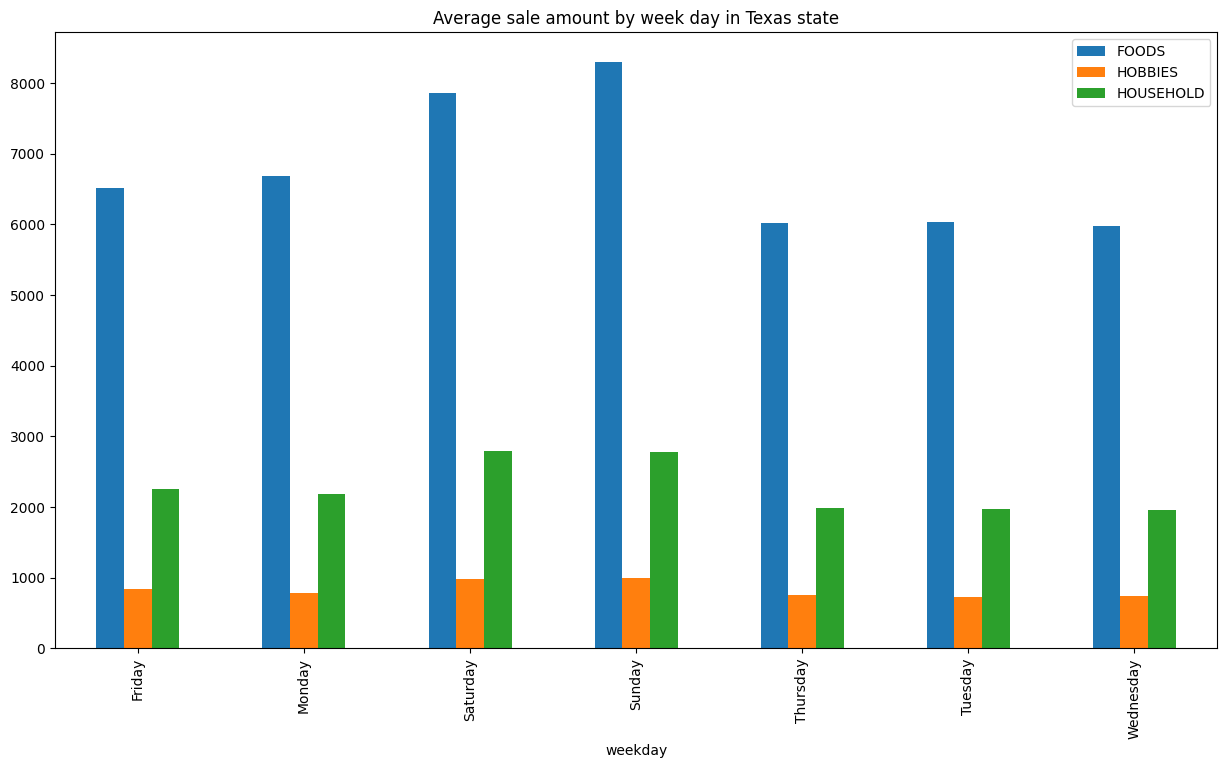

In [25]:
sales_sum_cat_TX = sales_raw[sales_raw['state_id'] == 'TX'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_cat_TXT = sales_sum_cat_TX.reset_index().rename(columns={'index': 'd'})
sales_sum_cat_joindate_TX = sales_sum_cat_TXT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_cat_avg_weekday_TX = sales_sum_cat_joindate_TX[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday_TX.plot.bar(figsize=(15,8), title='Average sale amount by week day in Texas state')

<Axes: title={'center': 'Average sale amount by week day in Iowa state'}, xlabel='weekday'>

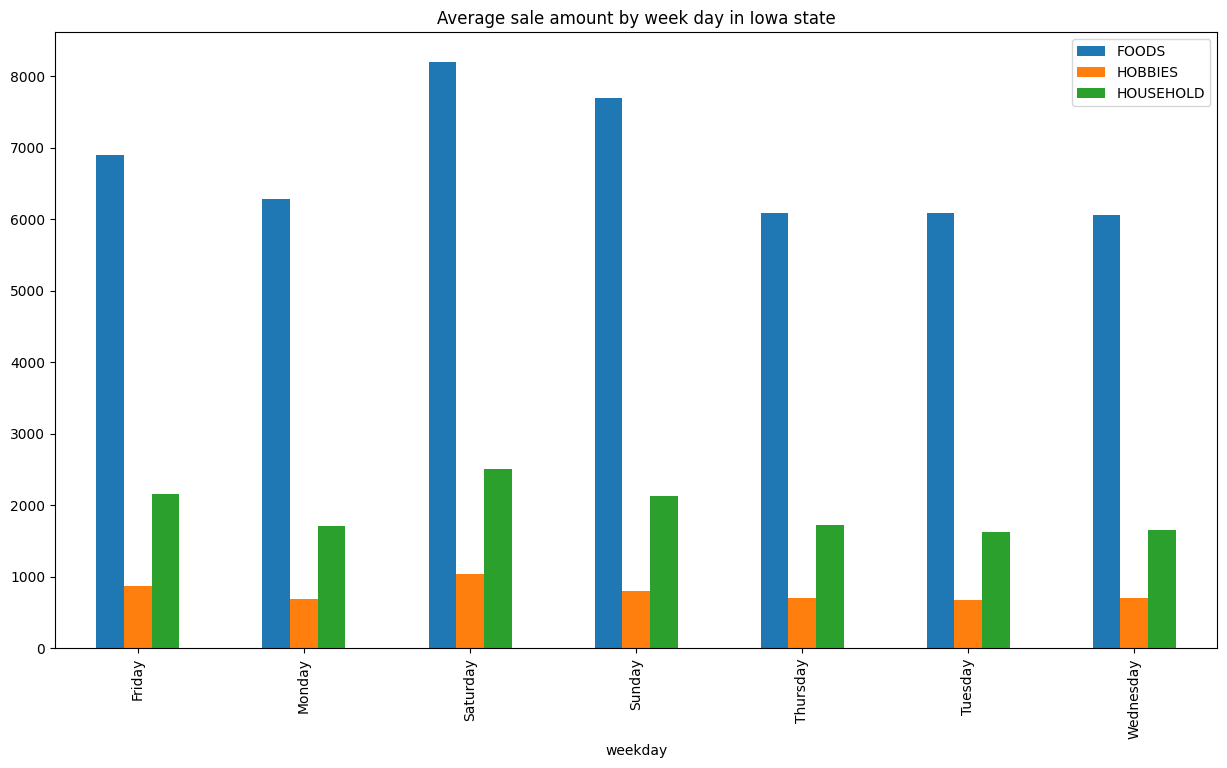

In [26]:
sales_sum_cat_WI = sales_raw[sales_raw['state_id'] == 'WI'].drop(columns=['id', 'item_id', 'dept_id', 'state_id']).groupby(['cat_id']).sum().T
sales_sum_cat_WIT = sales_sum_cat_WI.reset_index().rename(columns={'index': 'd'})
sales_sum_cat_joindate_WI = sales_sum_cat_WIT.merge(calendar_raw, how='left', validate='1:1').set_index('d')
sales_cat_avg_weekday_WI = sales_sum_cat_joindate_WI[['FOODS', 'HOBBIES', 'HOUSEHOLD', 'weekday']].groupby(['weekday']).mean()
sales_cat_avg_weekday_WI.plot.bar(figsize=(15,8), title='Average sale amount by week day in Iowa state')

***
#Summary
- We can see that the weekday have same effect on sale in every state. 
- The state have effect on sale amount. Thus, we must use state as another input for prediction model. 
- The weekday have a lot of effect on the sale amount. Thus, we should add week date to the model feature, so the model can understand and add some bias for each day.
***

***
# Feature selection
- state
- weekday
- category
- SNAP
- Price at date
***

In [27]:
cal = calendar_raw.drop(columns=['weekday', 'snap_TX', 'snap_WI'])
cal = cal.rename(columns={'snap_CA':'snap'})
cal.head()

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap
0,2011-01-29,11101,1,1,2011,d_1,NaN,NaN,NaN,NaN,0
1,2011-01-30,11101,2,1,2011,d_2,NaN,NaN,NaN,NaN,0
2,2011-01-31,11101,3,1,2011,d_3,NaN,NaN,NaN,NaN,0
3,2011-02-01,11101,4,2,2011,d_4,NaN,NaN,NaN,NaN,1
4,2011-02-02,11101,5,2,2011,d_5,NaN,NaN,NaN,NaN,1


In [62]:
sale_CA_1_raw = sales_raw[sales_raw['store_id'] == 'CA_1'].reset_index().drop(columns=['index', 'id'])
sale_CA_1_melted = sale_CA_1_raw.melt(id_vars=['item_id', 'dept_id', 'cat_id', 'store_id' , 'state_id'], var_name='d')
sale_CA_1_cal = sale_CA_1_melted.merge(cal, how='left', on='d')

sell_price_CA_1 = sell_price_raw[sell_price_raw['store_id'] == 'CA_1'].reset_index().drop(columns=['index', 'store_id'])
sale_CA_1_cal_price = sale_CA_1_cal.merge(sell_price_CA_1, how='left', on=['item_id', 'wm_yr_wk'])
sale_CA_1_cal_price.head()

,item_id,dept_id,cat_id,store_id,state_id,d,value,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,NaN,NaN,NaN,NaN,0,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,NaN,NaN,NaN,NaN,0,NaN


In [63]:
sale_CA_1_filled = sale_CA_1_cal_price.copy()
sale_CA_1_filled['sell_price'] = sale_CA_1_filled.groupby('item_id')['sell_price'].transform(lambda x: x.fillna(x.mean()))
sale_CA_1_filled['event_name_1'] = sale_CA_1_filled['event_name_1'].astype('str')
sale_CA_1_filled['event_name_1'] = sale_CA_1_filled['event_name_1'].apply(lambda x: event_name_to_id[x])
sale_CA_1_filled['event_name_2'] = sale_CA_1_filled['event_name_2'].astype('str')
sale_CA_1_filled['event_name_2'] = sale_CA_1_filled['event_name_2'].apply(lambda x: event_name_to_id[x])
sale_CA_1_filled['event_type_1'] = sale_CA_1_filled['event_type_1'].astype('str')
sale_CA_1_filled['event_type_1'] = sale_CA_1_filled['event_type_1'].apply(lambda x: event_type_to_id[x])
sale_CA_1_filled['event_type_2'] = sale_CA_1_filled['event_type_2'].astype('str')
sale_CA_1_filled['event_type_2'] = sale_CA_1_filled['event_type_2'].apply(lambda x: event_type_to_id[x])

sale_CA_1_filled['item_id'] = sale_CA_1_filled['item_id'].astype('str')
sale_CA_1_filled['item_id'] = sale_CA_1_filled['item_id'].apply(lambda x: item_to_id[x])
sale_CA_1_filled['dept_id'] = sale_CA_1_filled['dept_id'].astype('str')
sale_CA_1_filled['dept_id'] = sale_CA_1_filled['dept_id'].apply(lambda x: dept_to_id[x])
sale_CA_1_filled['cat_id'] = sale_CA_1_filled['cat_id'].astype('str')
sale_CA_1_filled['cat_id'] = sale_CA_1_filled['cat_id'].apply(lambda x: cat_to_id[x])

sale_CA_1_filled['store_id'] = sale_CA_1_filled['store_id'].astype('str')
sale_CA_1_filled['store_id'] = sale_CA_1_filled['store_id'].apply(lambda x: store_to_id[x])
sale_CA_1_filled['state_id'] = sale_CA_1_filled['state_id'].astype('str')
sale_CA_1_filled['state_id'] = sale_CA_1_filled['state_id'].apply(lambda x: state_to_id[x])

sale_CA_1_filled['date'] = pd.to_datetime(sale_CA_1_filled['date'])
sale_CA_1_filled['date'] = sale_CA_1_filled['date'].dt.day
sale_CA_1_filled = sale_CA_1_filled.rename(columns={'date': 'day'})
sale_CA_1_filled['d'] = sale_CA_1_filled['d'].apply(lambda x: int(x.split('_')[-1]))
sale_CA_1_filled = sale_CA_1_filled.drop(columns=['wm_yr_wk'])
sale_CA_1_filled.head()

,item_id,dept_id,cat_id,store_id,state_id,d,value,day,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,sell_price
0,0,0,0,0,0,1,0,29,1,1,2011,0,0,0,0,0,8.280059
1,1,0,0,0,0,1,0,29,1,1,2011,0,0,0,0,0,3.970000
2,2,0,0,0,0,1,0,29,1,1,2011,0,0,0,0,0,2.970000
3,3,0,0,0,0,1,0,29,1,1,2011,0,0,0,0,0,4.524824
4,4,0,0,0,0,1,0,29,1,1,2011,0,0,0,0,0,2.942965


In [30]:
def format_dataset(sale_table, seq_length=14, lag=7, skip=2):
    X = []
    y = []
    for item_id in tqdm(id_to_item, position=0, leave=True):
        item_group = sale_table[sale_table['item_id'] == item_id].sort_values(by='d')
        for index in range(0, len(item_group)-lag-seq_length, skip):
            row_range = item_group.iloc[index:index+seq_length]
            y.append(item_group.iloc[index+seq_length+lag]['value'])
            temp_X = row_range['value'].tolist()
            temp_X.extend(row_range['day'].tolist())
            temp_X.extend(row_range['wday'].tolist())
            temp_X.append(item_group.iloc[index]['month'])
            temp_X.append(item_group.iloc[index]['cat_id'])
            temp_X.append(item_group.iloc[index]['dept_id'])
            temp_X.extend(row_range['event_name_1'].tolist())
            temp_X.extend(row_range['event_type_1'].tolist())
            temp_X.extend(row_range['event_name_2'].tolist())
            temp_X.extend(row_range['event_type_2'].tolist())
            temp_X.extend(row_range['snap'].tolist())
            temp_X.append(row_range['sell_price'].mean())
            temp_X.append(item_group.iloc[index]['state_id'])
            temp_X.append(item_group.iloc[index]['store_id'])
            X.append(temp_X)
    return X, y

def save_dataset_csv(path, X, y):
    dataset = pd.DataFrame({'X': X, 'y': y})
    dataset.to_csv(path)

def read_dataset_csv(path):
    dataset = pd.read_csv(path)
    X = dataset['X']
    y = dataset['y']
    return X, y

In [78]:
def format_dataset(sale_table, seq_length=14, lag=7, skip=2):
    X = []
    y = []
    for item_id in tqdm(id_to_item, position=0, leave=True):
        item_group = sale_table[sale_table['item_id'] == item_id].sort_values(by='d')
        for index in range(0, len(item_group)-lag-seq_length, skip):
            row_range = item_group.iloc[index:index+seq_length]
            temp_X = {}
            y.append(item_group.iloc[index+seq_length+lag]['value'])
            temp_X['value'] = row_range['value'].tolist()
            temp_X['date'] = (row_range['day'].tolist())
            temp_X['wday'] = (row_range['wday'].tolist())
            temp_X['month'] = item_group.iloc[index]['month']
            temp_X['cat_id'] = item_group.iloc[index]['cat_id']
            temp_X['dept_id'] = item_group.iloc[index]['dept_id']
            temp_X['event_name_1'] = row_range['event_name_1'].tolist()
            temp_X['event_type_1'] = row_range['event_type_1'].tolist()
            temp_X['event_name_2'] = row_range['event_name_2'].tolist()
            temp_X['event_type_2'] = row_range['event_type_2'].tolist()
            temp_X['snap'] = row_range['snap'].tolist()
            temp_X['avg_sell_price'] = (row_range['sell_price'].mean())
            temp_X['state_id'] = item_group.iloc[index]['state_id']
            temp_X['store_id'] = item_group.iloc[index]['store_id']
            df = pd.DataFrame(temp_X)
            # print(df.head())
    # return X, y
df = format_dataset(sale_CA_1_filled)
df.head()
# X, y = format_dataset(sale_CA_1_filled)

  0%|          | 0/3049 [00:00<?, ?it/s]


,value,date,wday,month,cat_id,dept_id,event_name_1,event_type_1,event_name_2,event_type_2,snap,avg_sell_price,state_id,store_id
0,0,29,1,1.0,0.0,0.0,0,0,0,0,0,8.280059,0.0,0.0
1,0,30,2,1.0,0.0,0.0,0,0,0,0,0,8.280059,0.0,0.0
2,0,31,3,1.0,0.0,0.0,0,0,0,0,0,8.280059,0.0,0.0
3,0,1,4,1.0,0.0,0.0,0,0,0,0,1,8.280059,0.0,0.0
4,0,2,5,1.0,0.0,0.0,0,0,0,0,1,8.280059,0.0,0.0


In [40]:
# params = {
#     'task': 'train', 
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'num_leaves': 10,
#     'learnnig_rage': 0.05,
#     'metric': {'l2','l1'},
#     'verbose': -1
# }
model = lgb.LGBMRegressor()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [32]:
X, y = format_dataset(sale_CA_1_filled, skip=5)

100%|██████████| 3049/3049 [24:03<00:00,  2.11it/s]


In [44]:
train_ratio = 0.8
split_at = int(len(y) * train_ratio)

X_train = np.array(X[:split_at])
y_train = np.array(y[:split_at])
X_test = np.array(X[split_at:])
y_test = np.array(y[split_at:])

In [84]:
y_test.shape

(576871,)

In [85]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.339386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2476
[LightGBM] [Info] Number of data points in the train set: 2307483, number of used features: 102
[LightGBM] [Info] Start training from score 1.008815


LGBMRegressor()

In [89]:
model.score(X_test, y_test)

0.6667220574307164

In [96]:
y_pred = model.predict(X_test)

In [100]:
metrics.mean_squared_error(y_test, y_pred)

12.58795431085532

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

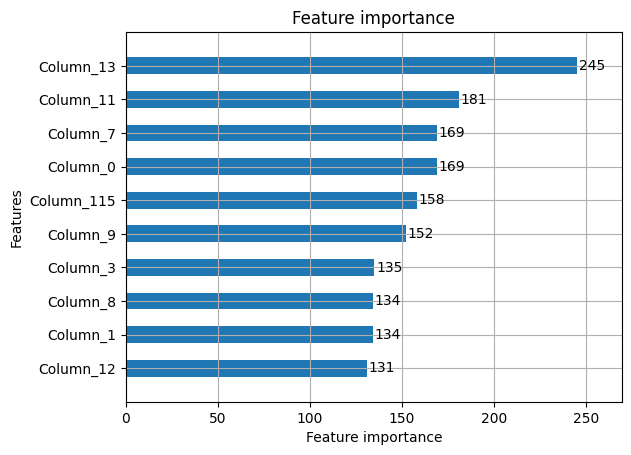

In [92]:
lgb.plot_importance(model, height=.5, max_num_features=10)